# Lab 7

## Event Selection Optimization

You and your lab partner should pick different pT (transverse momentum) samples (one uses low-pT sampels and the other use high-pT samples) for this lab. In each pT sample, there are dedicated training samples for event selection optimization. All studies should be carried out by normalizing Higgs and QCD samples in each pT sample to given expected yields accordingly (See Dataset descriptions).

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import poisson
from scipy.stats import norm
import pickle
import pandas as pd

In [2]:
# pickle read higgs and qcd files
higgs_file = open("Higgs_data/Sample_pt_250_500/higgs_100000_pt_250_500.pkl", 'rb')
higgs_dict = pickle.load(higgs_file)
qcd_file = open("Higgs_data/Sample_pt_250_500/qcd_100000_pt_250_500.pkl", 'rb')
qcd_dict = pickle.load(qcd_file)

print(higgs_dict.keys()) # qcd_dict has same keys

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


In [3]:
# pull out the arrays
pt_h = higgs_dict['pt']
eta_h = higgs_dict['eta']
phi_h = higgs_dict['phi']
mass_h = higgs_dict['mass']
ee2_h = higgs_dict['ee2']
ee3_h = higgs_dict['ee3']
d2_h = higgs_dict['d2']
ang_h = higgs_dict['angularity']
t1_h = higgs_dict['t1']
t2_h = higgs_dict['t2']
t3_h = higgs_dict['t3']
t21_h = higgs_dict['t21']
t32_h = higgs_dict['t32']
KtDeltaR_h = higgs_dict['KtDeltaR']

pt_q = qcd_dict['pt']
eta_q = qcd_dict['eta']
phi_q = qcd_dict['phi']
mass_q = qcd_dict['mass']
ee2_q = qcd_dict['ee2']
ee3_q = qcd_dict['ee3']
d2_q = qcd_dict['d2']
ang_q = qcd_dict['angularity']
t1_q = qcd_dict['t1']
t2_q = qcd_dict['t2']
t3_q = qcd_dict['t3']
t21_q = qcd_dict['t21']
t32_q = qcd_dict['t32']
KtDeltaR_q = qcd_dict['KtDeltaR']

## Problem 1

Make a stacked histogram plot for the feature variable: mass.

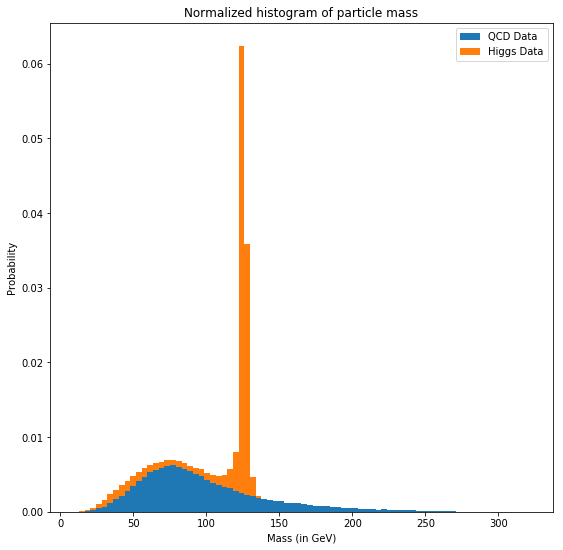

In [4]:
# Ok, we need to make this normalized, and want to stack h mass and q mass
figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist([mass_q, mass_h], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of particle mass")
ax.set_ylabel("Probability")
ax.set_xlabel("Mass (in GeV)")
ax.legend(["QCD Data", "Higgs Data"]);

Evaluate expected significance without any event selection.

In [5]:
# given N_qcd and N_higgs
N_qcd = 20000
N_higgs = 100

# Poisson statistics significance calculation
poisson_probability = poisson.cdf(N_qcd + N_higgs, N_qcd)
poisson_significance = norm.ppf(poisson_probability)
print("Poisson: " + str(poisson_significance))

analytic_probability = N_higgs / np.sqrt(N_qcd)
analytic_significance = norm.ppf(analytic_probability)
print("Analytic: " + str(analytic_significance))

Poisson: 0.7112259282313185
Analytic: 0.5449521356173602


The analytic significance is smaller than the poisson significance, which is interesting but seems reasonable because I don't understand why adding stuff is supposed to work. Neither are very good though, and something passing these thresholds doesn't really imply anything.

## Problem 2

Identify mass cuts to optimize the expected sigificance. Try different mass cuts systematically.

The optimal mass cuts will occur around the higgs value spike, so we want to find count values for that. Lets slice up masses into 5 chunks.

Evaluate expected significance for each set of mass cuts. Identify the set of the mass cuts which give you the highest significance.

In [6]:
# tweakables. Made generic for use later potentially.
feature_h = mass_h
feature_q = mass_q
cuts = 5    # breaks on cuts = 1 for some reason
start = 100
end = 150

# calculated
cut_size = (end - start) / cuts
cut_N_higgs = 0 # will result in 0% significance if no higgs data found
cut_N_qcd = 1 # prevents divide by 0 error
t_higgs = len(feature_h)
t_qcd = len(feature_q)

# outputs
best_probability = 0.0
best_lower = 0
best_upper = 0

for idx in range(0, cuts):
    lower = start + idx*cut_size
    upper = lower + cut_size
    
    # np.where returns a tuple for unknowable reasons, so we have to
    # extract the actually usable part.
    cut_h = np.where(np.logical_and(feature_h >= lower, 
                                    feature_h <= upper))[0]
    cut_q = np.where(np.logical_and(feature_q >= lower, 
                                    feature_q <= upper))[0]
    
    cut_N_higgs = len(cut_h) / t_higgs * N_higgs
    cut_N_qcd = len(cut_q) / t_qcd * N_qcd
    
    # Using this method because for some reason the other way doesn't
    # necessarily get a value between 0 and 1
    cut_probability = poisson.cdf(cut_N_higgs + cut_N_qcd, cut_N_qcd)
    
    if cut_probability > best_probability:
        best_probability = cut_probability
        best_lower = lower
        best_upper = upper
        best_N_higgs = cut_N_higgs
        best_N_qcd = cut_N_qcd

best_significance = norm.ppf(best_probability)
print("Best significance: " + str(best_significance))
print("Best cut: " + str(best_lower) + " - " + str(best_upper))

Best significance: 2.411688648925931
Best cut: 120.0 - 130.0


This significance is significantly better then uncut! Still not good enough for being used, but still a much needed improvement.

## Problem 3

Make stacked histogram plots for the rest of features.

Set A of plots without any selection. Can you identify another feature as discriminative as mass?

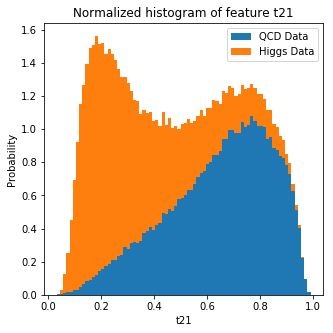

In [7]:
# since doing all features is a bit much, I shall choose a couple others.
# The features I shall investigate are t21, pT, and something that should be
# poor, like phi

figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([t21_q, t21_h], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of feature t21")
ax.set_ylabel("Probability")
ax.set_xlabel("t21")
ax.legend(["QCD Data", "Higgs Data"]);

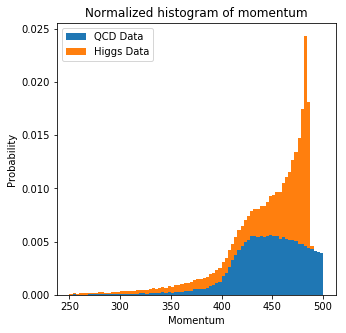

In [8]:
# On to pT
figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([pt_q, pt_h], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of momentum")
ax.set_ylabel("Probability")
ax.set_xlabel("Momentum")
ax.legend(["QCD Data", "Higgs Data"]);

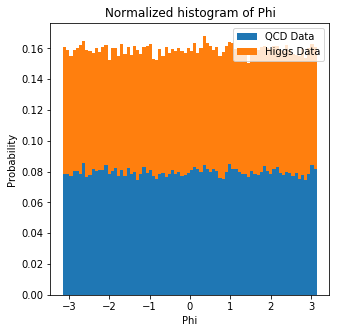

In [9]:
# Now on to something I think would probably be worse. Phi

figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([phi_q, phi_h], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of Phi")
ax.set_ylabel("Probability")
ax.set_xlabel("Phi")
ax.legend(["QCD Data", "Higgs Data"]);

Set B of plots with your optimal mass cuts. Can you identify additional features to further improve expected significance?

In [10]:
# Now lets take a look at the mass cut portions.
lower = best_lower # from above
upper = best_upper

mass_cut_h = np.where(np.logical_and(mass_h >= lower, 
                                           mass_h <= upper))[0]
mass_cut_q = np.where(np.logical_and(mass_q >= lower, 
                                           mass_q <= upper))[0]


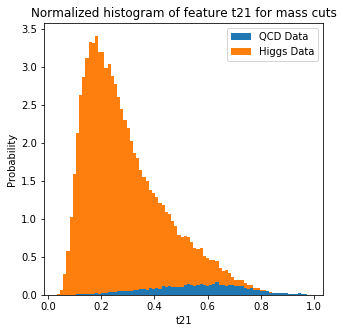

In [11]:
# Ok, now that we have our cut data indices, we can now look at the other data
figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([t21_q[mass_cut_q], t21_h[mass_cut_h]], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of feature t21 for mass cuts")
ax.set_ylabel("Probability")
ax.set_xlabel("t21")
ax.legend(["QCD Data", "Higgs Data"]);

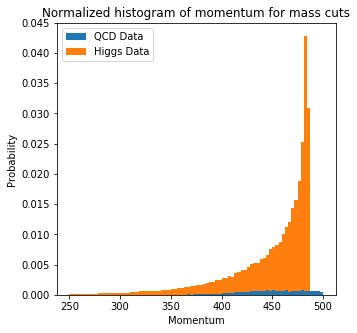

In [12]:
# On to pT
figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([pt_q[mass_cut_q], pt_h[mass_cut_h]], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of momentum for mass cuts")
ax.set_ylabel("Probability")
ax.set_xlabel("Momentum")
ax.legend(["QCD Data", "Higgs Data"]);

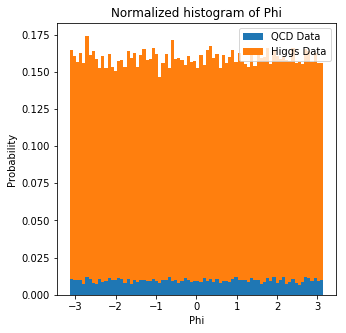

In [13]:
# Now on to something I think would probably be worse. Phi

figure = plt.figure(figsize=(5, 5))
ax = figure.subplots()

n, bins, patches = ax.hist([phi_q[mass_cut_q], phi_h[mass_cut_h]], bins=80, 
                           stacked=True, density=True);
ax.set_title("Normalized histogram of Phi")
ax.set_ylabel("Probability")
ax.set_xlabel("Phi")
ax.legend(["QCD Data", "Higgs Data"]);

t21 and momentum both seem like fairly reasonable options to further optimize values.

## Problem 4
Optimize event selections using multiple features (if necessary)

Find a set of feature cuts which can help you to achieve the best significance.

In [14]:
# Lets stack mass and momentum

# tweakables. Haha, I knew this would happen!
feature_h = pt_h[mass_cut_h]
feature_q = pt_q[mass_cut_q]
cuts = 10    # breaks on cuts = 1 for some reason 
start = 0.0
end = 1.0

# calculated
cut_size = (end - start) / cuts
cut_N_higgs = 0 # will result in 0% significance if no higgs data found
cut_N_qcd = 1 # prevents divide by 0 error
t_higgs = len(pt_h) # scale to original
t_qcd = len(pt_h)

# outputs
best_probability = 0.0
best_lower = 0
best_upper = 0

for idx in range(0, cuts):
    lower = start + idx*cut_size
    upper = lower + cut_size
    
    # np.where returns a tuple for unknowable reasons, so we have to
    # extract the actually usable part.
    cut_h = np.where(np.logical_and(feature_h >= lower, 
                                    feature_h <= upper))[0]
    cut_q = np.where(np.logical_and(feature_q >= lower, 
                                    feature_q <= upper))[0]
    
    cut_N_higgs = len(cut_h) / t_higgs * best_N_higgs
    cut_N_qcd = len(cut_q) / t_qcd * best_N_qcd
    
    # Using this method because for some reason the other way doesn't
    # necessarily get a value between 0 and 1
    cut_probability = poisson.cdf(cut_N_higgs + cut_N_qcd, cut_N_qcd)
    
    if cut_probability > best_probability:
        best_probability = cut_probability
        best_lower = lower
        best_upper = upper
        best_cut_q = cut_q
        best_cut_h = cut_h

best_significance = norm.ppf(best_probability)
print("Best significance: " + str(best_significance))
print("Best cut: " + str(best_lower) + " - " + str(best_upper))

Best significance: inf
Best cut: 0.0 - 0.1


...So there are no background events at this range, so any event we witness within this mass and momentum cut is gauranteed to be a signal. Lets check the significance around the spike to, since that is probably where we care the most.

In [15]:
# tweakables. Haha, I knew this would happen!
feature_h = pt_h[mass_cut_h]
feature_q = pt_q[mass_cut_q]
cuts = 10
start = 400.0
end = 500

# calculated
cut_size = (end - start) / cuts
cut_N_higgs = 0 # will result in 0% significance if no higgs data found
cut_N_qcd = 1 # prevents divide by 0 error
t_higgs = len(pt_h)
t_qcd = len(pt_q)

# outputs
best_probability = 0.0
best_lower = 0
best_upper = 0

for idx in range(0, cuts):
    lower = start + idx*cut_size
    upper = lower + cut_size
    
    # np.where returns a tuple for unknowable reasons, so we have to
    # extract the actually usable part.
    cut_h = np.where(np.logical_and(feature_h >= lower, 
                                    feature_h <= upper))[0]
    cut_q = np.where(np.logical_and(feature_q >= lower, 
                                    feature_q <= upper))[0]
    
    cut_N_higgs = len(cut_h) / t_higgs * N_higgs
    cut_N_qcd = len(cut_q) / t_qcd * N_qcd
    
    # Using this method because for some reason the other way doesn't
    # necessarily get a value between 0 and 1
    cut_probability = poisson.cdf(cut_N_higgs + cut_N_qcd, cut_N_qcd)
    
    if cut_probability > best_probability:
        best_probability = cut_probability
        best_lower = lower
        best_upper = upper

best_significance = norm.ppf(best_probability)
print("Best significance: " + str(best_significance))
print("Best cut: " + str(best_lower) + " - " + str(best_upper))

Best significance: 2.1036943732596143
Best cut: 480.0 - 490.0


Hmm, how odd. I am confused as to why significance is down. Perhaps I don't understand what N_higgs and N_qcd are supposed to be for momentum, I thought they would be the same as before.

Compare significance (before/after event selection) derived in your pT samples to your lab partner. Describe your findings.

My initial sigma was 0.71, peaking at 2.41 with mass cuts, and a 2.10 for mass and momentum cuts. While not as impressive as my partners jump from 1.1282 to 5.9323 sigma, it is still an improvement in significance. I'm sure my mistake is silly and obvious.

# Lab 8

## Pseudo-experiment data analysis

Using your optimized event selection, hunt for your signal by using one of the pseudo-experiment dataset. For each task below, you will choose one of the observed data from your specific pT sample to perform the analysis.

In [16]:
hi_lumi_file = "Higgs_data/Sample_pt_250_500/data_highLumi_pt_250_500.h5"
hi_data = pd.read_hdf(hi_lumi_file)

lo_lumi_file = "Higgs_data/Sample_pt_250_500/data_lowLumi_pt_250_500.h5"
lo_data = pd.read_hdf(lo_lumi_file)

In [17]:
# Since I used only pt and mass previously, I will only extract those
mass_hi = hi_data["mass"]
pt_hi = hi_data["pt"]
mass_lo = lo_data["mass"]
pt_lo = lo_data["pt"]

# I am not going to utilize the momentum data just now, until I figure out
# why my sigma for that cut is so wacky

## High luminosity data

Focus on each feature of your event selection. Plot observed data, overlap with expected signal and background (normalized to observed yields) without event selection.

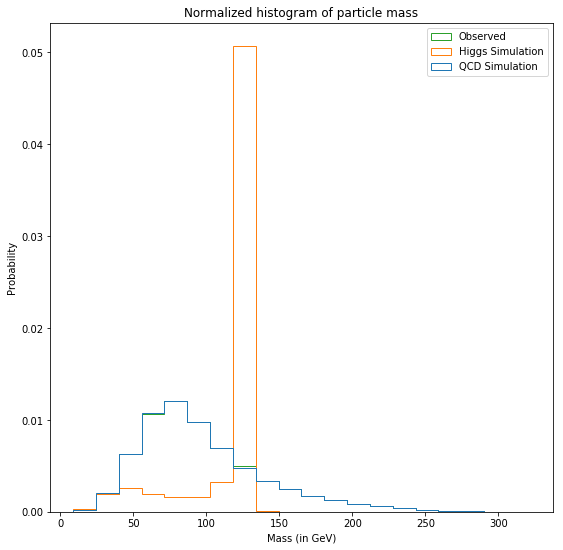

In [18]:
# this is just showing off another one of these histograms, this time
# not stacked
figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist([mass_q, mass_h, mass_hi], bins=20, 
                           histtype='step', density=True);
ax.set_title("Normalized histogram of particle mass")
ax.set_ylabel("Probability")
ax.set_xlabel("Mass (in GeV)")
# Dear god, why is the order reversed for the legend now? I swear...
ax.legend(["Observed", "Higgs Simulation", "QCD Simulation"]);

The Observed data is very close to the QCD simulation. Concerning. I made the bins wider so that the observed "bump" at the higgs spike is more visible.

Plot observed data, overlap with expected signal and background (normalized to observed yields) with optimal event selection.

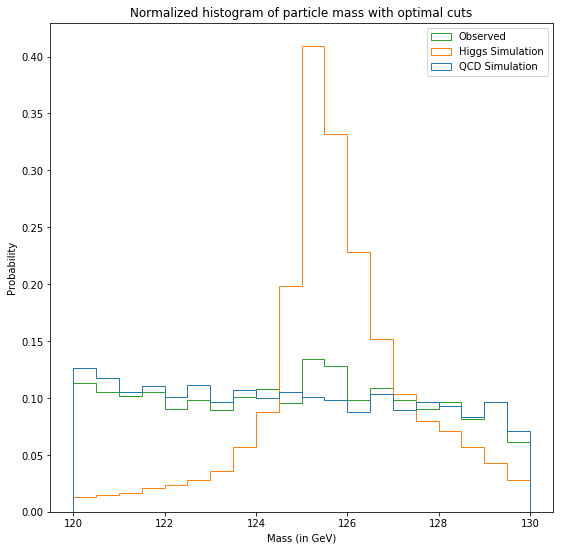

In [19]:
# I shall use the best cut from lab 7 on the observed data.
lower = 120
upper = 130

cut_h = np.where(np.logical_and(mass_h >= lower, 
                                mass_h <= upper))[0]
cut_q = np.where(np.logical_and(mass_q >= lower, 
                                mass_q <= upper))[0]
cut_hi = np.where(np.logical_and(mass_hi >= lower, 
                                 mass_hi <= upper))[0]

optimal_h = mass_h[cut_h]
optimal_q = mass_q[cut_q]
optimal_hi = mass_hi[cut_hi]

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist([optimal_q, optimal_h, optimal_hi], bins=20, 
                           histtype='step', density=True);
ax.set_title("Normalized histogram of particle mass with optimal cuts")
ax.set_ylabel("Probability")
ax.set_xlabel("Mass (in GeV)")
ax.legend(["Observed", "Higgs Simulation", "QCD Simulation"]);

Evaluate observed significance and compare your results to expectation.

In [20]:
cut_N_hi = len(optimal_hi)
cut_N_higgs = len(optimal_h)
cut_N_qcd = len(optimal_q)

# Not quite sure what to do here, will swing back around to this.

## Low luminosity data

Focus on each feature of your event selection. Plot observed data, overlap with expected signal and background (normalized to observed yields) without event selection.

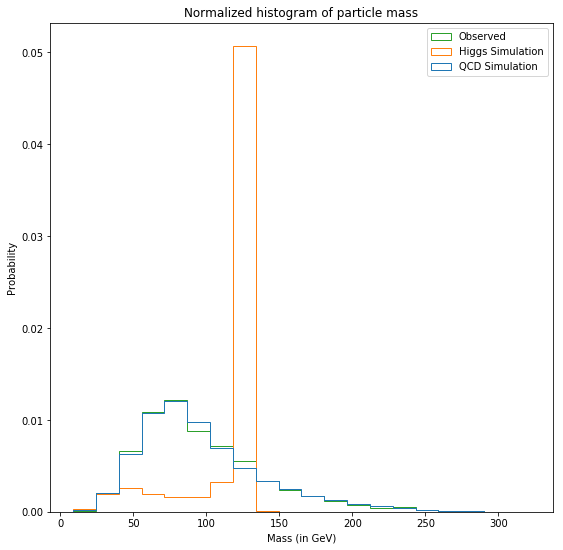

In [21]:
# Same exact thing as last time, but with low luminosity data
figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist([mass_q, mass_h, mass_lo], bins=20, 
                           histtype='step', density=True);
ax.set_title("Normalized histogram of particle mass")
ax.set_ylabel("Probability")
ax.set_xlabel("Mass (in GeV)")
# Dear god, why is the order reversed for the legend now? I swear...
ax.legend(["Observed", "Higgs Simulation", "QCD Simulation"]);

Plot observed data, overlap with expected signal and background (normalized to observed yields) with optimal event selection.

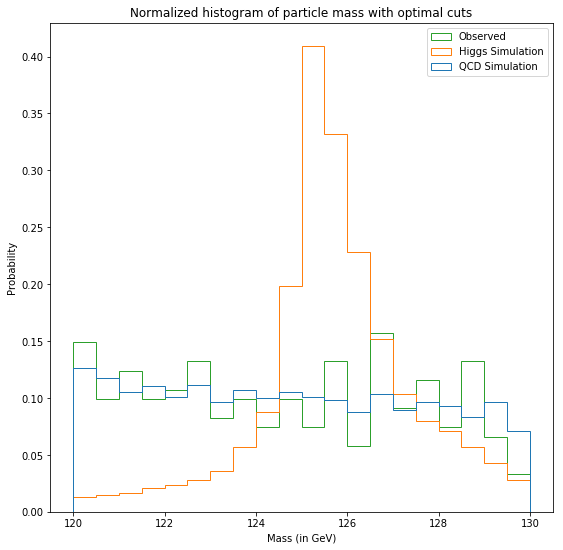

In [22]:
lower = 120
upper = 130

cut_h = np.where(np.logical_and(mass_h >= lower, 
                                mass_h <= upper))[0]
cut_q = np.where(np.logical_and(mass_q >= lower, 
                                mass_q <= upper))[0]
cut_lo = np.where(np.logical_and(mass_lo >= lower, 
                                 mass_lo <= upper))[0]

optimal_h = mass_h[cut_h]
optimal_q = mass_q[cut_q]
optimal_lo = mass_lo[cut_lo]

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist([optimal_q, optimal_h, optimal_lo], bins=20, 
                           histtype='step', density=True);
ax.set_title("Normalized histogram of particle mass with optimal cuts")
ax.set_ylabel("Probability")
ax.set_xlabel("Mass (in GeV)")
ax.legend(["Observed", "Higgs Simulation", "QCD Simulation"]);

Evaluate observed significance and compare your results to expectation.

In [23]:
cut_N_lo = len(optimal_lo)
cut_N_higgs = len(optimal_h)
cut_N_qcd = len(optimal_q)

# Not quite sure what to do here, will swing back around to this.

## 95% Confidence Level of signal yields

In the low luminosity data, the observed significance is less than 5 sigma, We will calculate the 95% confidence level upper limit of signal yield.

Evaluate the expected 95% confidence level upper limit

Evaluate the observed 95% confidence level upper limit

Compare expectation to observation. Comment on your finding.